In [1]:
import shutil
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import cv2
import torch
from PIL import Image

/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 1. Make predictions

Run predictions on all validation data

In [2]:
#https://www.kaggle.com/code/jigglediggle1/global-wheat-detection-yolo
def predict(images_path:"path to the test images", weights_path: "path to the weights folder"):
    """
    Helper function to make predictions over images using Yolo
    """
    os.system(
        f"""
            python yolov5/detect.py --source {images_path} --weights {weights_path}
        """)

predict(images_path = "yolov5/bcc/images/valid",
       weights_path = 'yolov5_trained_cells.pt')

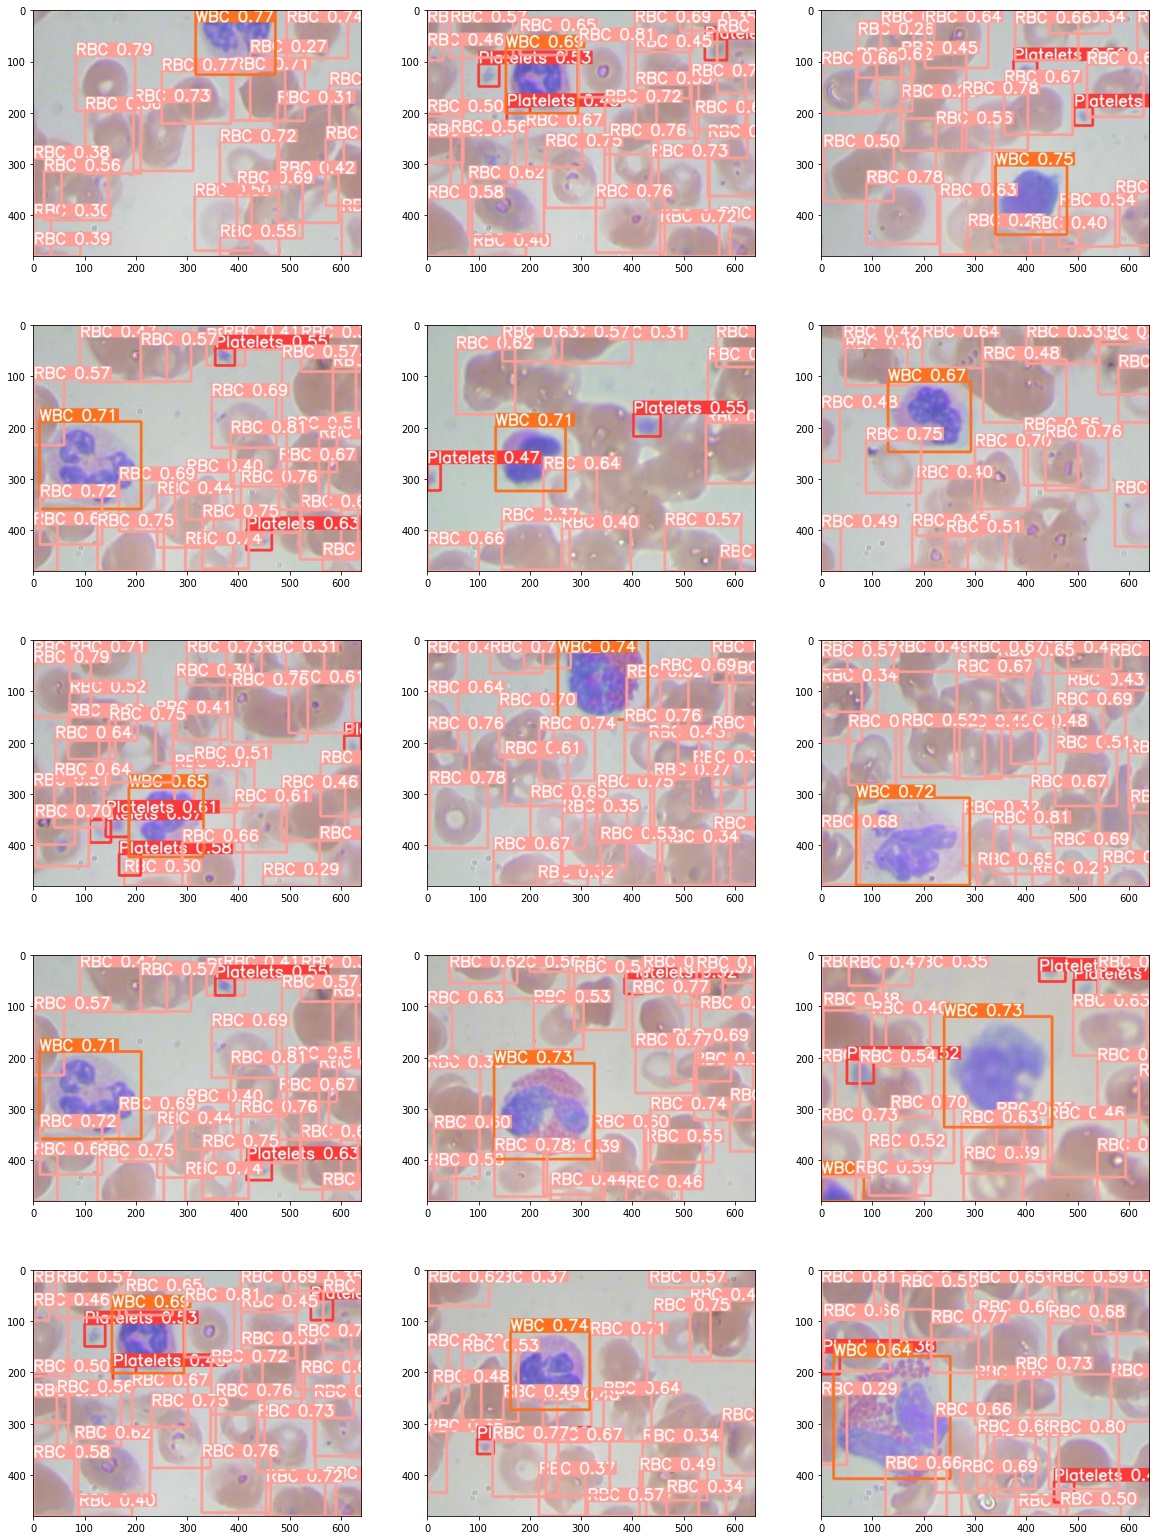

In [5]:
disp_images = glob("yolov5/runs/detect/exp11/*")
fig=plt.figure(figsize=(20, 28))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)

    plt.imshow(img)
plt.show()


#### Reporting
Initial template module one image at a time (not folder (aka experiment) -wise) because of Streamlit limitations
- 🍇 Raw: each object detected and its features
-  📊Count number of each cell type per image
- 🎯Compute average size of each cell type



Import model

In [7]:
# Model
model_path = "yolov5_trained_cells.pt"
model = torch.hub.load('yolov5', 'custom', source='local', path=model_path)

YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.8.5 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [8]:
mapping_classes =  {0: "Platelets", 1: "RBC", 2: "WBC"}

In [9]:
## version only one image at a time

image = "yolov5/bcc/images/valid/BloodImage_00005.jpg"
im = cv2.imread(image)[:, :, ::-1] 
# result.show() to show image with detections
result = model([im], size=640)
tensor = result.xyxy
array = tensor[0].numpy()
raw_df = pd.DataFrame(array, columns=['x1', 'y1', 'x2', 'y2', 'confidence', 'class'])

In [10]:
raw_df['class'] = raw_df['class'].apply(lambda x: mapping_classes[x])

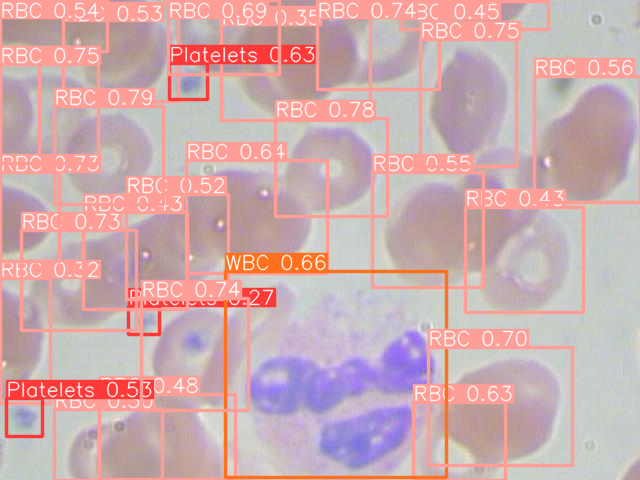

In [11]:
result.show()

In [12]:
raw_df.head()

,x1,y1,x2,y2,confidence,class
0,54.290409,106.415924,163.273560,204.272095,0.790796,RBC
1,275.684570,118.919029,387.221680,216.184570,0.781385,RBC
2,420.048492,39.118778,516.893311,166.173523,0.752074,RBC
3,0.000000,64.377518,98.117767,163.226334,0.745436,RBC
4,317.760651,0.000000,439.799835,89.930176,0.741775,RBC


In [18]:
count_df = raw_df.groupby('class').count()

# Rename the column to 'count'
count_df = pd.DataFrame(count_df.rename(columns={'confidence': 'count'})['count'])
count_df

,count
class,
Platelets,3
RBC,25
WBC,1


In [21]:
sizes_df = raw_df.copy()
sizes_df['box_area'] = (raw_df['x2']-raw_df['x1'])*(raw_df['y2']-raw_df['y1'])
sizes_df

,x1,y1,x2,y2,confidence,class,box_area
0,54.290409,106.415924,163.273560,204.272095,0.790796,RBC,10664.673828
1,275.684570,118.919029,387.221680,216.184570,0.781385,RBC,10848.717773
2,420.048492,39.118778,516.893311,166.173523,0.752074,RBC,12304.593750
3,0.000000,64.377518,98.117767,163.226334,0.745436,RBC,9698.825195
4,317.760651,0.000000,439.799835,89.930176,0.741775,RBC,10975.004883
5,141.220627,298.843933,248.882675,410.657837,0.740054,RBC,12038.114258
6,0.000000,172.980515,59.197472,261.967743,0.731393,RBC,5267.818848
7,21.501057,230.426178,136.635071,330.568878,0.725169,RBC,11529.831055
8,428.001404,347.538727,572.327576,465.080902,0.704551,RBC,16964.412109
9,168.755951,0.000000,279.614899,74.490555,0.685444,RBC,8257.944336
